# Hannah Zhao - Week 1 DenseNet Model with MIL
## MIL (Multiple Instance Learning) stops you from punishing for “normal‐looking” patches in High-grade cases by moving supervision up to the case level
#### changes include: MIL on H&E stained patches with Max-pooling for the bag-level pooling
#### overall results:  not the best, but definitely requires more exploration (address class imbalance, try different bag-level pooling techniques)

In [2]:
# Standard library imports
import os
import re
import random
import shutil
from datetime import datetime
from collections import OrderedDict

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and TorchVision libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
from PIL import Image

# Scikit-Learn for evaluation metrics and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Imbalanced-learn for oversampling to address class imbalance
from imblearn.over_sampling import RandomOverSampler

from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image

In [3]:
# Define local file paths

# Define your Desktop folder based on your OS; this uses the user's home directory.
desktop = os.path.join(os.path.expanduser("~"), "Desktop")

# Path to the filtered patches folder on your Desktop
filtered_patches_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "filtered_patches")

# Path to the CSV file inside Desktop/uni/STAT 390/Hannah Zhao
csv_file_path = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "case_grade_match.csv")

# Directory to store model checkpoints
checkpoint_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "Checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

In [4]:
# load labels 
labels = pd.read_csv(csv_file_path)

In [5]:
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)  # Using regex for case number extraction
        if match:
            case_num = int(match.group(1))
            if case_num not in case_patches:
                case_patches[case_num] = []
            case_patches[case_num].append(os.path.join(patch_dir, filename))
    return case_patches

patches = group_patches(filtered_patches_dir)

from PIL import Image, ImageStat

# attempting to filter out images that may be mostly white with irrelevent information
def is_tissue_patch(img: Image.Image, bg_thresh: float = 0.85) -> bool:
    """
    Return True if less than bg_thresh fraction of this patch is background.
    We approximate “background” as “very white” by looking at the mean intensity
    in the grayscale image.
    """
    gray = img.convert("L")
    stat = ImageStat.Stat(gray)
    mean_intensity = stat.mean[0] / 255.0
    return mean_intensity < bg_thresh


In [6]:
# ---------------------------
# Transforms
# ---------------------------
class PadToSquare:
    def __call__(self, img: Image.Image) -> Image.Image:
        w,h = img.size
        if w==h: return img
        diff = abs(w-h)
        if w<h:
            left, right = diff//2, diff-diff//2
            pad = (left,0,right,0)
        else:
            top, bottom = diff//2, diff-diff//2
            pad = (0,top,0,bottom)
        return F.pad(img, pad, fill=0)

transform = transforms.Compose([
    PadToSquare(),
    transforms.Resize((224,224)),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [7]:
# ---------------------------
# Prepare case split
# ---------------------------
case_nums = list(patches.keys())
# align CSV indexing if needed
dataset = labels.loc[[(x-1) for x in case_nums]]
mask = dataset['Class'] != 2.0
X = dataset[mask].Case.reset_index(drop=True)
y = dataset[mask].Class.reset_index(drop=True)

train_X, test_X, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=40)
train_X, val_X, y_train, y_val = train_test_split(train_X,y_train,test_size=0.2,stratify=y_train,random_state=40)

train_patches = {c:patches[int(c)] for c in train_X}
val_patches   = {c:patches[int(c)] for c in val_X}
test_patches  = {c:patches[int(c)] for c in test_X}

# optional: filter to just one stain
stain="h&e"
def filter_by_stain(d,kw):
    out={}
    for c,paths in d.items():
        f=[p for p in paths if kw.lower() in os.path.basename(p).lower()]
        if f: out[c]=f
    return out

train_patches = filter_by_stain(train_patches, stain)
val_patches   = filter_by_stain(val_patches,   stain)
test_patches  = filter_by_stain(test_patches,  stain)

In [8]:
# ---------------------------
# MIL Dataset & Model
# ---------------------------
class MILDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None, bg_thresh=0.85):
        self.transform = transform
        self.bags, self.labels = [], []
        for case, paths in case_patches.items():
            raw = labels_df.loc[labels_df['Case']==case,'Class'].item()
            bag_lbl = 0 if raw==1 else 1
            keep=[]
            for p in paths:
                img=Image.open(p).convert('RGB')
                if is_tissue_patch(img,bg_thresh): keep.append(p)
            if keep:
                self.bags.append(keep)
                self.labels.append(bag_lbl)
    def __len__(self): return len(self.bags)
    def __getitem__(self, idx):
        paths = self.bags[idx]
        imgs = []
        for p in paths:
            img = Image.open(p).convert('RGB')
            if self.transform: img = self.transform(img)
            imgs.append(img)
        return torch.stack(imgs), torch.tensor(self.labels[idx],dtype=torch.long)

class MILDenseNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        base = models.densenet121(pretrained=True)
        self.features   = base.features
        self.pool       = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(base.classifier.in_features, num_classes)
    def forward(self, x):
        # x: [B, M, 3, H, W]
        B,M,C,H,W = x.shape
        x = x.view(B*M, C, H, W)
        f = self.features(x)
        f = self.pool(f).view(B*M, -1)
        logit = self.classifier(f).view(B, M, -1)
        bag_logit, _ = logit.max(dim=1)
        return bag_logit

In [9]:
# ---------------------------
# DataLoaders
# ---------------------------
train_ds = MILDataset(train_patches, labels, transform=transform)
val_ds   = MILDataset(val_patches,   labels, transform=transform)
test_ds  = MILDataset(test_patches,  labels, transform=transform)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False)


In [25]:
# number of high grade cases in the training
sum(train_ds.labels)

23

In [10]:
sum(train_ds.labels)/len(train_ds.labels)

0.7419354838709677

In [11]:
# number of total cases in the training 
len(train_ds)

31

In [12]:
train_ds[0]

(tensor([[[[-1.7240, -1.7240, -1.7240,  ..., -1.2274, -1.5699, -1.7240],
           [-1.7240, -1.6213, -1.5528,  ..., -1.0219, -1.5699, -1.7240],
           [-1.7240, -1.3987, -1.0390,  ..., -0.6623, -1.3987, -1.7240],
           ...,
           [-1.7240, -1.7240, -1.6727,  ..., -1.2445, -1.6727, -1.7240],
           [-1.7240, -1.7240, -1.7240,  ..., -1.5699, -1.7240, -1.7240],
           [-1.7240, -1.7240, -1.7240,  ..., -1.7240, -1.7240, -1.7240]],
 
          [[-1.6331, -1.6331, -1.6331,  ..., -1.2654, -1.5105, -1.6331],
           [-1.6331, -1.5280, -1.4755,  ..., -1.0728, -1.5105, -1.6331],
           [-1.6331, -1.3529, -1.0378,  ..., -0.7927, -1.3704, -1.6331],
           ...,
           [-1.6331, -1.6331, -1.5805,  ..., -1.2479, -1.5805, -1.6331],
           [-1.6331, -1.6331, -1.6331,  ..., -1.5105, -1.6331, -1.6331],
           [-1.6331, -1.6331, -1.6331,  ..., -1.6331, -1.6331, -1.6331]],
 
          [[-1.4036, -1.4036, -1.4036,  ..., -0.8284, -1.2293, -1.4036],
           [-

In [13]:
# ---------------------------
# Train / Validate routines
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = MILDenseNet(2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)

def validation(model, crit, loader):
    model.eval()
    tot_loss, tot_acc = 0,0
    with torch.no_grad():
        for X_bag, y in loader:
            X_bag, y = X_bag.to(device), y.to(device)
            logits = model(X_bag)
            tot_loss += crit(logits, y).item()
            preds = logits.argmax(dim=1)
            tot_acc  += (preds==y).float().mean().item()
    return tot_loss/len(loader), tot_acc/len(loader)

def train_model(model, opt, crit, tr_ld, val_ld, epochs=5):
    for e in range(epochs):
        model.train()
        run_loss=0
        for X_bag, y in tr_ld:
            X_bag, y = X_bag.to(device), y.to(device)
            opt.zero_grad()
            logits = model(X_bag)
            loss   = crit(logits, y)
            loss.backward()
            opt.step()
            run_loss += loss.item()
        vl, va = validation(model,crit,val_ld)
        print(f"Epoch {e+1}/{epochs}  TrainLoss={run_loss/len(tr_ld):.3f}  ValLoss={vl:.3f}  ValAcc={va:.3f}")
    return model

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# ---------------------------
# Run training
# ---------------------------
model = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5)

Epoch 1/5  TrainLoss=0.742  ValLoss=0.702  ValAcc=0.375
Epoch 2/5  TrainLoss=0.646  ValLoss=0.695  ValAcc=0.625
Epoch 3/5  TrainLoss=0.636  ValLoss=0.619  ValAcc=0.625
Epoch 4/5  TrainLoss=0.630  ValLoss=0.539  ValAcc=0.750
Epoch 5/5  TrainLoss=0.636  ValLoss=0.680  ValAcc=0.750


In [19]:
model.eval()
all_preds, all_trues = [], []

with torch.no_grad():
    for X_bag, y in test_loader:
        # X_bag: [M, C, H, W]   y: tensor(label)
        X_bag = X_bag.to(device)
        y      = y.to(device)
        
        # make it [1, M, C, H, W] if needed
        if X_bag.dim() == 4:
            X_bag = X_bag.unsqueeze(0)
        
        # forward --> [1, num_classes]
        logits = model(X_bag)
        
        # pick bag‐level prediction
        pred = logits.argmax(dim=1).item()
        
        all_preds.append(pred)
        all_trues.append(y.item())

                 precision    recall  f1-score   support

         Benign       0.00      0.00      0.00         4
High‐grade CMIL       0.56      0.83      0.67         6

       accuracy                           0.50        10
      macro avg       0.28      0.42      0.33        10
   weighted avg       0.33      0.50      0.40        10



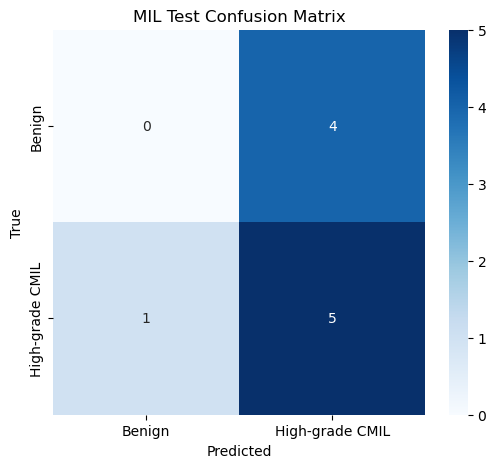

In [20]:
# classification report
print(classification_report(all_trues, all_preds, target_names=['Benign','High‐grade CMIL']))

# confusion matrix
cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign','High‐grade CMIL'],
            yticklabels=['Benign','High‐grade CMIL'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MIL Test Confusion Matrix")
plt.show()